In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Define the path to your dataset
#change according to your file directory
data_path = r"C:\Users\umara\OneDrive\Desktop\University\COMP 432\COMP432Proj\Dataset 1"

reason for mean and STD initialization 
check out this discussion: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2


In [5]:
# Transformation pipeline: Resize all images to be of the same size
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using ImageNet mean and STD
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes  # List of class names inferred from folder names
print(f"Labels: {class_names}")

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Labels: ['MUS', 'NORM', 'STR']


In [6]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


(tensor([[[ 0.2111,  0.5193,  1.3927,  ..., -0.0801, -0.2684,  0.0912],
         [-0.2684, -0.1314,  1.3755,  ..., -0.3369, -0.5938, -0.1486],
         [-0.1828,  0.2453,  1.9749,  ...,  0.0056, -0.3198, -0.2513],
         ...,
         [ 0.6221,  0.8618,  1.0673,  ...,  0.9132,  1.4098,  1.3413],
         [ 0.6392,  0.9474,  1.0673,  ...,  1.0159,  1.1187,  1.1700],
         [ 0.5022,  0.8447,  1.1187,  ...,  1.4783,  1.2385,  1.0844]],

        [[-0.4776, -0.2675,  0.4678,  ..., -0.7577, -0.8627, -0.5301],
         [-0.9853, -0.8452,  0.4503,  ..., -0.8277, -1.1604, -0.8978],
         [-0.7927, -0.5301,  0.8004,  ..., -0.6527, -1.0203, -0.9153],
         ...,
         [-0.2150,  0.0301, -0.0049,  ..., -0.1625,  0.2927,  0.2752],
         [-0.3550, -0.0224, -0.0224,  ...,  0.1877,  0.0826,  0.2227],
         [-0.5651, -0.1975, -0.0224,  ...,  0.9055,  0.4153,  0.1352]],

        [[ 0.9145,  1.0365,  1.8034,  ...,  0.6531,  0.4439,  1.0191],
         [ 0.3916,  0.4962,  1.7337,  ...,  

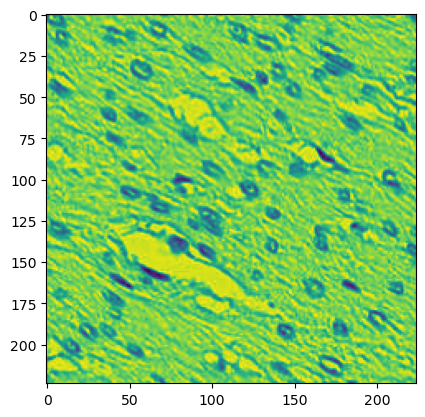

In [7]:
#Visualize some pics
image , label = dataset[0]
print(dataset[0])  # Check what this returns

# image = cv2.imread(image)
plt.imshow(image[0])

In [8]:
# Load the ResNet-18 model with no pre-trained weights
model = models.resnet18()

# Modify the final layer to match the number of classes (3 in this case: MUS, NORM, STR)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss function (Cross-Entropy Loss) and optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Training function for ResNet-18 model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate validation loss and accuracy
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        # Compute average loss and accuracy for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return model

In [11]:
# Train the model with specified number of epochs
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


KeyboardInterrupt: 